In [1]:
import matplotlib
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

In [45]:
# !pip install ibats_common
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import ensemble, preprocessing, metrics
from ibats_common.backend.factor import get_factor
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import datetime
from vnpy.trader.constant import Exchange, Interval
from vnpy.trader.database import database_manager
import ffn  # NOQA
import matplotlib
# 使用 Jupyter 内置方式显示
matplotlib.use('module://ipykernel.pylab.backend_inline')


In [3]:


def plot_bar(symbol="RB2010", exchange=Exchange.SHFE, interval=Interval.MINUTE,
             start=datetime(2019, 4, 1), end=datetime(2020, 10, 30),
             label_count=15, fig_size=(16, 6), label_rotation=15, time_format='%Y-%m-%d %H:%M:%S'):
    # Load history data
    bars = database_manager.load_bar_data(
        symbol=symbol, exchange=exchange,
        interval=interval, start=start, end=end)

    # Generate x, y
    x = [bar.datetime for bar in bars]
    y = [bar.close_price for bar in bars]

    # Show plot
    y_len = len(y)
    xticks = list(range(0, y_len, y_len // label_count))
    xlabels = [x[_].strftime(time_format) for _ in xticks]
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=label_rotation)
    plt.plot(y)
    plt.title(f"{symbol} {interval.value} {min(x).strftime(time_format)}~{max(x).strftime(time_format)}")
    plt.legend([symbol])
    plt.show()

2020-09-21 11:32:33,885 DEBUG peewee peewee.py.execute_sql:3087|('SELECT `t1`.`id`, `t1`.`symbol`, `t1`.`exchange`, `t1`.`datetime`, `t1`.`interval`, `t1`.`volume`, `t1`.`open_interest`, `t1`.`open_price`, `t1`.`high_price`, `t1`.`low_price`, `t1`.`close_price` FROM `dbbardata` AS `t1` WHERE (((((`t1`.`symbol` = %s) AND (`t1`.`exchange` = %s)) AND (`t1`.`interval` = %s)) AND (`t1`.`datetime` >= %s)) AND (`t1`.`datetime` <= %s)) ORDER BY `t1`.`datetime`', ['RB2009', 'SHFE', '1m', datetime.datetime(2019, 4, 1, 0, 0), datetime.datetime(2020, 10, 30, 0, 0)])


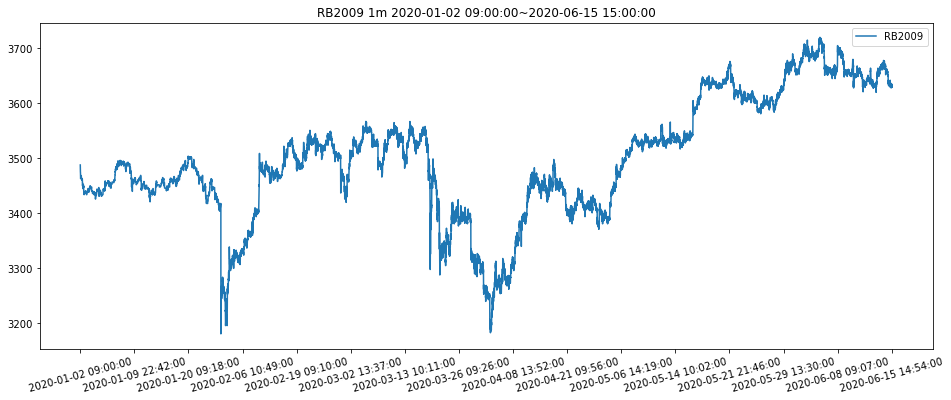

In [4]:
plot_bar(symbol="RB2009")

In [5]:
from ibats_common.backend.factor import get_factor

BAR_ATTRIBUTES = [
    'open_price', 'high_price', 'low_price', 'close_price',
    'datetime', 'volume',
]

def generate_factors(hist_bar_list):
    """整理缓存数据，生成相应的因子"""
    df = pd.DataFrame(
        [{key: getattr(_, key) for key in BAR_ATTRIBUTES}
         for _ in hist_bar_list]).set_index('datetime')
    df.index = pd.to_datetime(df.index)

    # 生成因子
    factor_df = get_factor(
        df,
        ohlcav_col_name_list=['open_price', 'high_price', 'low_price', 'close_price', None, 'volume'],
        dropna=False
    )
    return df, factor_df


获取数据

In [6]:
symbol="RB2009"
exchange=Exchange.SHFE
interval=Interval.MINUTE
start=datetime(2019, 4, 1)
end=datetime(2020, 10, 30)
bars = database_manager.load_bar_data(
    symbol=symbol, exchange=exchange,
    interval=interval, start=start, end=end)


2020-09-21 11:32:35,911 DEBUG peewee peewee.py.execute_sql:3087|('SELECT `t1`.`id`, `t1`.`symbol`, `t1`.`exchange`, `t1`.`datetime`, `t1`.`interval`, `t1`.`volume`, `t1`.`open_interest`, `t1`.`open_price`, `t1`.`high_price`, `t1`.`low_price`, `t1`.`close_price` FROM `dbbardata` AS `t1` WHERE (((((`t1`.`symbol` = %s) AND (`t1`.`exchange` = %s)) AND (`t1`.`interval` = %s)) AND (`t1`.`datetime` >= %s)) AND (`t1`.`datetime` <= %s)) ORDER BY `t1`.`datetime`', ['RB2009', 'SHFE', '1m', datetime.datetime(2019, 4, 1, 0, 0), datetime.datetime(2020, 10, 30, 0, 0)])


In [7]:
bars[0], bars[0].datetime, bars[-1].datetime

(BarData(gateway_name='DB', symbol='RB2009', exchange=<Exchange.SHFE: 'SHFE'>, datetime=datetime.datetime(2020, 1, 2, 9, 0, tzinfo=<DstTzInfo 'Asia/Shanghai' LMT+8:06:00 STD>), interval=<Interval.MINUTE: '1m'>, volume=3.0, open_interest=2149.0, open_price=3488.0, high_price=3488.0, low_price=3488.0, close_price=3488.0),
 datetime.datetime(2020, 1, 2, 9, 0, tzinfo=<DstTzInfo 'Asia/Shanghai' LMT+8:06:00 STD>),
 datetime.datetime(2020, 6, 15, 15, 0, tzinfo=<DstTzInfo 'Asia/Shanghai' LMT+8:06:00 STD>))

构建因子矩阵

In [8]:
hist_bar_df, factor_df = generate_factors(bars)
len(bars), hist_bar_df.shape, factor_df.shape

(29047, (29047, 5), (29047, 111))

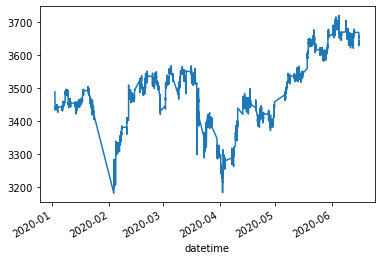

In [9]:
hist_bar_df['close_price'].plot()
plt.show()

构建y数据

In [95]:
target_n_bars = 5
y_s = hist_bar_df['close_price'].rolling(
    window=target_n_bars).apply(lambda x: x.calc_calmar_ratio())  # calc_total_return calc_calmar_ratio
y_s[np.isneginf(y_s)]=-100
y_s[np.isposinf(y_s)]=100
np.sum(y_s<=0), np.sum(y_s>0)

(13387, 11565)

数据整理，剔除无效数据

In [96]:
# 剔除无效数据，并根据 target_n_bars 进行数据切片
is_available = ~(np.isinf(y_s) | np.isnan(y_s) | np.any(np.isnan(factor_df), axis=1))
available_hist_bar_df = hist_bar_df[is_available].iloc[:-target_n_bars]
available_factor_df = factor_df[is_available].iloc[:-target_n_bars]
x_arr = available_factor_df.to_numpy()
y_arr = y_s[is_available][target_n_bars:]
assert x_arr.shape[0] == y_arr.shape[0], "因子数据 x 长度要与训练目标 y 数据长度一致"

# 生成 -1 1 分类结果
y_arr[y_arr > 0] = 1
y_arr[y_arr <= 0] = -1
x_train_arr, x_test_arr, y_train_arr, y_test_arr = train_test_split(
    x_arr, y_arr, test_size=0.3)
x_arr.shape, y_arr.shape, np.sum(y_arr==-1), np.sum(y_arr==1)

((24868, 111), (24868,), 13328, 11540)

创建分类器

In [97]:
# Train classifier
# 弱学习器的最大迭代次数，
# n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，
# 一般选择一个适中的数值。默认是50。
# 在实际调参的过程中，我们常常将n_estimators和learning_rate一起考虑。
n_estimators = 50
# 对于同样的训练集拟合效果，
# 较小的ν意味着我们需要更多的弱学习器的迭代次数。
# 通常用步长和迭代最大次数一起来决定算法的拟合效果。
# 所以这两个参数n_estimators和learning_rate要一起调参。
# 一般来说，可以从一个小一点的ν开始调参，默认是1。
learning_rate = 1.0
scaler = preprocessing.MinMaxScaler()
clf = ensemble.AdaBoostClassifier(
    n_estimators=n_estimators, learning_rate=learning_rate)

开始训练

In [98]:
x_train_trans_arr = scaler.fit_transform(x_train_arr)
# print 'type(X_train_trans),X_train_trans[:5,:]\n%s\n%s'%(type(X_train_trans),X_train_trans[:5,:])
# print 'type(Y_train),Y_train.head()\n%s\n%s'%(type(Y_train),Y_train.head())
clf.fit(x_train_trans_arr, y_train_arr)
# 交叉检验
y_pred = clf.predict(x_train_trans_arr)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(y_train_arr, y_pred) * 100))
x_test_trans = scaler.transform(x_test_arr)
y_pred = clf.predict(x_test_trans)
y_pred_prob = clf.predict_proba(x_test_trans)
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(y_test_arr, y_pred) * 100))
print('Log-loss on test set = {:.5f}'.format(metrics.log_loss(y_test_arr, y_pred_prob) * 100))

Accuracy on train set = 57.91%
Accuracy on test set = 55.62%
Log-loss on test set = 69.24820


In [115]:
print('目标结果占比情况')
for value, count in Counter(y_test_arr).items():
    print(f'{int(value):2d} 共 {count:4d} 次，占比{count/y_test_arr.shape[0]*100:5.2f}%')
print('预测结果占比情况')
for value, count in Counter(y_pred).items():
    print(f'{int(value):2d} 共 {count:4d} 次，占比{count/y_pred.shape[0]*100:5.2f}%')

df = pd.DataFrame(
    {value: {'value':value, '次数': count, '占比': count / y_test_arr.shape[0] * 100}
             for value, count in Counter(y_test_arr).items()},
).T.set_index('value').join(pd.DataFrame(
    {value: {'value':value, '次数': count, '占比': count / y_pred.shape[0] * 100}
             for value, count in Counter(y_pred).items()},
).T.set_index('value'), how='outer', on='value', lsuffix='(目标)', rsuffix='(预测)')

df

目标结果占比情况
-1 共 4031 次，占比54.03%
 1 共 3430 次，占比45.97%
预测结果占比情况
 1 共 2717 次，占比36.42%
-1 共 4744 次，占比63.58%


,次数(目标),占比(目标),次数(预测),占比(预测)
value,,,,
-1.0000,"4,031.0000",54.0276,"4,744.0000",63.5840
1.0000,"3,430.0000",45.9724,"2,717.0000",36.4160


开始交叉验证训练

In [92]:
import itertools

scaler = preprocessing.MinMaxScaler()
x_trans_arr = scaler.fit_transform(x_arr)
for rate, n in itertools.product([1.0, 0.5, 0.1], range(20, 80, 10)):
    estimator = ensemble.AdaBoostClassifier(
    n_estimators=n, learning_rate=rate)
    result = np.array(cross_val_score(estimator, x_trans_arr, y_arr)) * 100
    print(f'n={n:3d} rate={rate:.2f} mean_res={np.mean(result):.2f}, std_res={np.std(result):.5f}, result={result}')

n= 20 rate=1.00 mean_res=49.39, std_res=2.67711, result=[45.98436389 52.74569042 49.72454238 46.72116581 51.78603163]
n= 30 rate=1.00 mean_res=48.65, std_res=3.13261, result=[42.83937456 50.89745868 49.26248445 48.44499733 51.78603163]
n= 40 rate=1.00 mean_res=49.40, std_res=2.15718, result=[46.35749822 51.41283099 50.02665719 47.43202417 51.78603163]
n= 50 rate=1.00 mean_res=50.52, std_res=1.29570, result=[52.30987918 50.07997157 49.26248445 49.17362715 51.78603163]
n= 60 rate=1.00 mean_res=48.03, std_res=3.92621, result=[41.29353234 52.14146081 47.62751022 47.30762396 51.78603163]
n= 70 rate=1.00 mean_res=47.57, std_res=3.86456, result=[40.45842217 49.65345655 48.88928381 47.07659499 51.78603163]
n= 20 rate=0.50 mean_res=47.55, std_res=4.60973, result=[40.90262971 51.43060245 50.55980096 43.07801671 51.78603163]
n= 30 rate=0.50 mean_res=48.06, std_res=4.34853, result=[41.43567875 51.55500267 51.25288786 44.26870446 51.78603163]
n= 40 rate=0.50 mean_res=48.18, std_res=4.41381, result=

In [117]:
import itertools

scaler = preprocessing.MinMaxScaler()
x_trans_arr = scaler.fit_transform(x_arr)
for rate, n in itertools.product([1.0, 0.5, 0.1], range(20, 80, 10)):
    estimator = ensemble.AdaBoostClassifier(
    n_estimators=n, learning_rate=rate)
    result = np.array(cross_val_score(estimator, x_trans_arr, y_arr)) * 100
    print(f'n={n:3d} rate={rate:.2f} mean_res={np.mean(result):.2f}, std_res={np.std(result):.5f}, result={result}')

n= 20 rate=1.00 mean_res=51.75, std_res=2.69114, result=[46.60233213 52.61359067 51.80940893 54.11220591 53.58938267]
n= 30 rate=1.00 mean_res=51.46, std_res=2.69362, result=[46.50180941 51.58825895 51.50784077 54.1323145  53.58938267]
n= 40 rate=1.00 mean_res=51.57, std_res=2.80501, result=[46.38118215 51.32689988 52.15118617 54.37361753 53.60949125]
n= 50 rate=1.00 mean_res=51.44, std_res=2.48015, result=[46.70285485 51.72899075 51.86972256 53.26764528 53.60949125]
n= 60 rate=1.00 mean_res=51.23, std_res=2.42445, result=[46.70285485 51.4274226  51.4274226  53.00623366 53.60949125]
n= 70 rate=1.00 mean_res=51.09, std_res=2.37126, result=[46.60233213 51.66867712 51.40731805 52.18178162 53.60949125]
n= 20 rate=0.50 mean_res=52.24, std_res=2.85363, result=[46.6827503  52.59348613 53.6389224  54.67524633 53.58938267]
n= 30 rate=0.50 mean_res=52.01, std_res=2.85115, result=[46.62243667 51.72899075 53.47808605 54.63502916 53.58938267]
n= 40 rate=0.50 mean_res=51.79, std_res=2.77764, result=

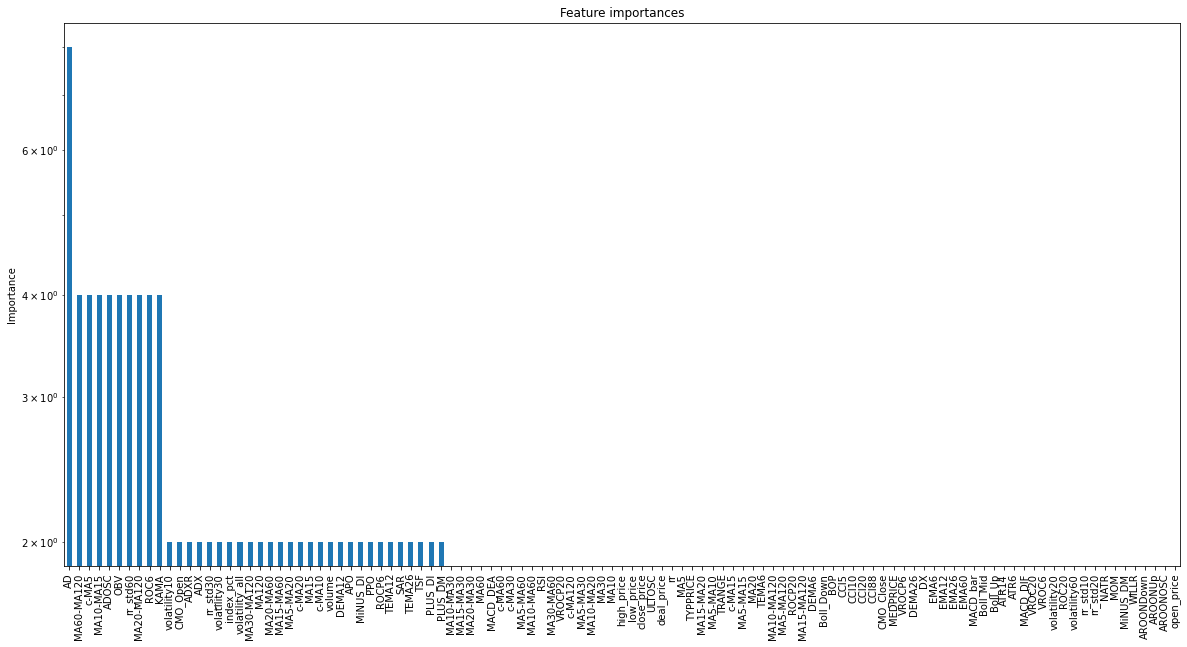

In [116]:
feature_importances = pd.Series(clf.feature_importances_, index=factor_df.columns) * 100
feature_importances.sort_values(ascending=False, inplace=True)
ax = feature_importances.plot(kind='bar', figsize=(20,10))
ax.set(ylabel='Importance', title='Feature importances');
ax.set_yscale("log")

尝试使用近20天的数据，滚动向前，查看预测未来5天的Y值准确率，以及 feature importance 的变化情况

In [118]:
win_size_days = 20
predict_future_n_days = 5

def get_available_arr(dates, date_s, x_df, y_arr):
    date_from, date_to = pd.to_datetime(dates.min()), pd.to_datetime(dates.max())
    sub_available = ((date_from<=date_s) & (date_s<date_to)).to_numpy()
    sub_factor_df = x_df[sub_available]
    sub_y_arr = y_arr[sub_available]
    return date_from, date_to, sub_factor_df, sub_y_arr

def train_and_valid(available_factor_df, y_arr, win_size_days, predict_future_n_days):
    # 有效历史数据的日期序列
    available_factor_df_date_s = pd.Series(available_factor_df.index, index=available_factor_df.index).apply(lambda x:x.date())
    # Unique 日期序列
    date_s = pd.Series(available_factor_df_date_s.unique())
    predict_dic = {}
    for idx in range(win_size_days, date_s.shape[0]-predict_future_n_days):
        # 建立训练集
        date_from, date_to, sub_factor_df, sub_y_train_arr =get_available_arr(
            date_s.iloc[idx-win_size_days:idx], available_factor_df_date_s, available_factor_df, y_arr)
        # 建立分类器
        estimator = ensemble.AdaBoostClassifier(n_estimators=n, learning_rate=rate)
        scaler = preprocessing.MinMaxScaler()
        sub_x_trans_arr = scaler.fit_transform(sub_factor_df.to_numpy())
        # 训练
        clf.fit(sub_x_trans_arr, sub_y_train_arr)
        # 建立验证集
        _, _, sub_factor_df, sub_y_test_arr =get_available_arr(
            date_s.iloc[idx:idx+predict_future_n_days], available_factor_df_date_s, available_factor_df, y_arr)
        # 交叉检验
        sub_y_train_pred = clf.predict(sub_x_trans_arr)
        # print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(sub_y_train_arr, sub_y_pred) * 100))
        sub_y_test_pred = clf.predict(scaler.transform(sub_factor_df.to_numpy()))
        sub_y_pred_prob = clf.predict_proba(scaler.transform(sub_factor_df.to_numpy()))
        # print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(sub_y_test_arr, sub_y_pred) * 100))
        # print('Log-loss on test set = {:.5f}%'.format(metrics.log_loss(sub_y_test_arr, sub_y_pred_prob) * 100))
        predict_dic[date_to] = {
            'Accuracy on train': metrics.accuracy_score(sub_y_train_arr, sub_y_train_pred) * 100,
            'Accuracy on test': metrics.accuracy_score(sub_y_test_arr, sub_y_test_pred) * 100,
            'Log-loss on test': metrics.log_loss(sub_y_test_arr, sub_y_pred_prob) * 100,
        }
        if len(np.unique(sub_y_test_pred)) == 1:
            print(f'date_to {date_to} 未来n日预测结果只有一个结果 {np.unique(sub_y_test_pred)[0]}')
        else:
            print(f'date_to {date_to} 训练完成')

predict_df = train_and_valid(available_factor_df, y_arr, win_size_days, predict_future_n_days)

date_to 2020-02-06 00:00:00 训练完成
date_to 2020-02-07 00:00:00 训练完成
date_to 2020-02-10 00:00:00 训练完成
date_to 2020-02-11 00:00:00 训练完成
date_to 2020-02-12 00:00:00 训练完成
date_to 2020-02-13 00:00:00 训练完成
date_to 2020-02-14 00:00:00 训练完成
date_to 2020-02-17 00:00:00 训练完成
date_to 2020-02-18 00:00:00 训练完成
date_to 2020-02-19 00:00:00 训练完成
date_to 2020-02-20 00:00:00 训练完成
date_to 2020-02-21 00:00:00 训练完成
date_to 2020-02-24 00:00:00 训练完成
date_to 2020-02-25 00:00:00 训练完成
date_to 2020-02-26 00:00:00 训练完成
date_to 2020-02-27 00:00:00 训练完成
date_to 2020-02-28 00:00:00 训练完成
date_to 2020-03-02 00:00:00 训练完成
date_to 2020-03-03 00:00:00 训练完成
date_to 2020-03-04 00:00:00 训练完成
date_to 2020-03-05 00:00:00 训练完成
date_to 2020-03-06 00:00:00 训练完成
date_to 2020-03-09 00:00:00 训练完成
date_to 2020-03-10 00:00:00 训练完成
date_to 2020-03-11 00:00:00 未来n日预测结果只有一个结果 -1.0
date_to 2020-03-12 00:00:00 训练完成
date_to 2020-03-13 00:00:00 训练完成
date_to 2020-03-16 00:00:00 训练完成
date_to 2020-03-17 00:00:00 训练完成
date_to 2020-03-18 00:00:00 

In [119]:
pd.DataFrame({'target':sub_y_test_arr, 'predict':sub_y_test_pred})


,target,predict
datetime,,
2020-06-08 09:02:00+08:00,-1.0000,-1.0000
2020-06-08 09:03:00+08:00,-1.0000,-1.0000
2020-06-08 09:04:00+08:00,1.0000,-1.0000
2020-06-08 09:05:00+08:00,1.0000,-1.0000
2020-06-08 09:06:00+08:00,-1.0000,-1.0000
...,...,...
2020-06-12 08:54:00+08:00,1.0000,-1.0000
2020-06-12 08:55:00+08:00,-1.0000,-1.0000
2020-06-12 08:56:00+08:00,-1.0000,-1.0000


,Accuracy on train,Accuracy on test,Log-loss on test
2020-02-06,83.2674,68.5575,62.7726
2020-02-07,81.8760,68.7023,64.8792
2020-02-10,81.7248,69.6921,64.4444
2020-02-11,80.0597,70.3892,63.7530
2020-02-12,78.4332,70.1299,63.5334
...,...,...,...
2020-06-01,67.3746,68.9792,65.9516
2020-06-02,68.1996,70.5419,64.3474
2020-06-03,67.7393,69.3215,66.5333
2020-06-04,68.0083,71.5655,64.5037


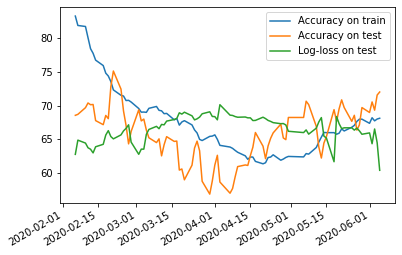

In [120]:
predict_df = pd.DataFrame(predict_dic).T
predict_df.plot()
predict_df

date_to 2020-02-20 00:00:00 训练完成
date_to 2020-02-21 00:00:00 训练完成
date_to 2020-02-24 00:00:00 训练完成
date_to 2020-02-25 00:00:00 训练完成
date_to 2020-02-26 00:00:00 训练完成
date_to 2020-02-27 00:00:00 训练完成
date_to 2020-02-28 00:00:00 训练完成
date_to 2020-03-02 00:00:00 训练完成
date_to 2020-03-03 00:00:00 训练完成
date_to 2020-03-04 00:00:00 训练完成
date_to 2020-03-05 00:00:00 训练完成
date_to 2020-03-06 00:00:00 训练完成
date_to 2020-03-09 00:00:00 训练完成
date_to 2020-03-10 00:00:00 训练完成
date_to 2020-03-11 00:00:00 训练完成
date_to 2020-03-12 00:00:00 训练完成
date_to 2020-03-13 00:00:00 训练完成
date_to 2020-03-16 00:00:00 训练完成
date_to 2020-03-17 00:00:00 训练完成
date_to 2020-03-18 00:00:00 训练完成
date_to 2020-03-19 00:00:00 训练完成
date_to 2020-03-20 00:00:00 训练完成
date_to 2020-03-23 00:00:00 未来n日预测结果只有一个结果 1.0
date_to 2020-03-24 00:00:00 训练完成
date_to 2020-03-25 00:00:00 训练完成
date_to 2020-03-26 00:00:00 训练完成
date_to 2020-03-27 00:00:00 训练完成
date_to 2020-03-30 00:00:00 未来n日预测结果只有一个结果 -1.0
date_to 2020-03-31 00:00:00 训练完成
date_to 2020-0

,Accuracy on train,Accuracy on test,Log-loss on test
2020-02-06,83.2674,68.5575,62.7726
2020-02-07,81.8760,68.7023,64.8792
2020-02-10,81.7248,69.6921,64.4444
2020-02-11,80.0597,70.3892,63.7530
2020-02-12,78.4332,70.1299,63.5334
...,...,...,...
2020-06-01,67.3746,68.9792,65.9516
2020-06-02,68.1996,70.5419,64.3474
2020-06-03,67.7393,69.3215,66.5333
2020-06-04,68.0083,71.5655,64.5037


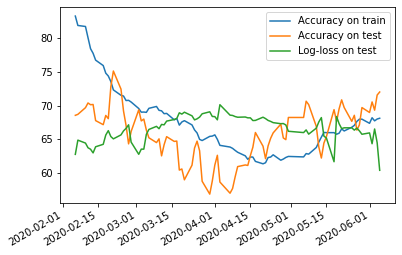

In [121]:
win_size_days = 30
predict_future_n_days = 5
predict_df = train_and_valid(available_factor_df, y_arr, win_size_days, predict_future_n_days)
predict_df = pd.DataFrame(predict_dic).T
predict_df.plot()
predict_df

,Accuracy on train,Accuracy on test,Log-loss on test
2020-02-06,83.2674,68.5575,62.7726
2020-02-07,81.8760,68.7023,64.8792
2020-02-10,81.7248,69.6921,64.4444
2020-02-11,80.0597,70.3892,63.7530
2020-02-12,78.4332,70.1299,63.5334
...,...,...,...
2020-06-01,67.3746,68.9792,65.9516
2020-06-02,68.1996,70.5419,64.3474
2020-06-03,67.7393,69.3215,66.5333
2020-06-04,68.0083,71.5655,64.5037


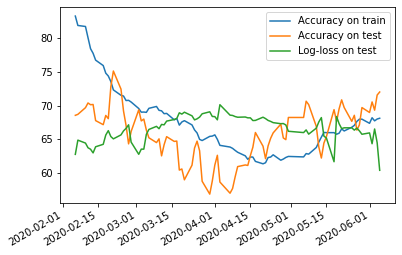

In [26]:
win_size_days = 20
predict_future_n_days = 10
predict_df = train_and_valid(available_factor_df, y_arr, win_size_days, predict_future_n_days)
predict_df = pd.DataFrame(predict_dic).T
predict_df.plot()
predict_df

,Accuracy on train,Accuracy on test,Log-loss on test
2020-02-06,83.2674,68.5575,62.7726
2020-02-07,81.8760,68.7023,64.8792
2020-02-10,81.7248,69.6921,64.4444
2020-02-11,80.0597,70.3892,63.7530
2020-02-12,78.4332,70.1299,63.5334
...,...,...,...
2020-06-01,67.3746,68.9792,65.9516
2020-06-02,68.1996,70.5419,64.3474
2020-06-03,67.7393,69.3215,66.5333
2020-06-04,68.0083,71.5655,64.5037


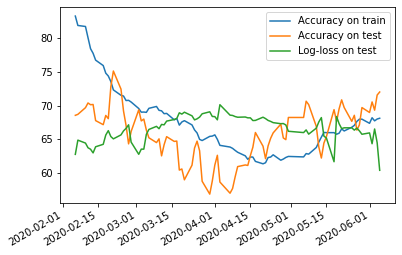

In [27]:
win_size_days = 30
predict_future_n_days = 10
predict_df = train_and_valid(available_factor_df, y_arr, win_size_days, predict_future_n_days)
predict_df = pd.DataFrame(predict_dic).T
predict_df.plot()
predict_df